In [1]:
import json

import numpy as np

from scipy import stats

from pathlib import Path

from overcast import models
from overcast import datasets
from overcast.models import ensembles
from overcast.visualization import plotting

from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
rc = {
    "figure.constrained_layout.use": True,
    "figure.facecolor": "white",
    "axes.labelsize": 20,
    "axes.titlesize": 18,
    "legend.frameon": True,
    "figure.figsize": (6, 6),
    "legend.fontsize": 18,
    "legend.title_fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
}
_ = sns.set(style="whitegrid", palette="colorblind", rc=rc)

In [3]:
TARGET_KEYS = {
    "Nd": "N_d", 
    "re": r"$r_e$", 
    "COD": r"$\tau$",
    "CWP": "CWP", 
    "LPC": r"$CF_w$",
}

In [4]:
class Experiment:
    def __init__(self, experiment_path, name):
        self.experiment_dir = Path(experiment_path)
        self.transformer = True if "daily" in experiment_path else False
        config_path = self.experiment_dir / "config.json"
        self.checkpoint_dir = self.experiment_dir / "checkpoints"
        self.ensemble_dir = self.experiment_dir
        self.name = name

        with open(config_path) as cp:
            config = json.load(cp)

        config["ds_test"]["data_dir"] = "/scratch/ms21mmso/data"
        config["ds_valid"]["data_dir"] = "/scratch/ms21mmso/data"
        config["ds_train"]["data_dir"] = "/scratch/ms21mmso/data"

        self.dataset_name = config.get("dataset_name")
        self.num_components_outcome = config.get("num_components_outcome")
        self.num_components_treatment = config.get("num_components_treatment")
        self.dim_hidden = config.get("dim_hidden")
        self.depth = config.get("depth")
        self.negative_slope = config.get("negative_slope")
        self.beta = config.get("beta")
        self.layer_norm = config.get("layer_norm")
        self.dropout_rate = config.get("dropout_rate")
        self.spectral_norm = config.get("spectral_norm")
        self.learning_rate = config.get("learning_rate")
        self.batch_size = config.get("batch_size")
        self.epochs = config.get("epochs")
        self.ensemble_size = config.get("ensemble_size")
        self.num_heads = config.get("num_heads") if self.transformer is True else None

        self.ds = {
            "test": datasets.DATASETS.get(self.dataset_name)(**config.get("ds_test")),
            "valid": datasets.DATASETS.get(self.dataset_name)(**config.get("ds_valid")),
            "train": datasets.DATASETS.get(self.dataset_name)(**config.get("ds_train")),
        }

        self.target_keys = dict(
            (k, v) for (k, v) in enumerate(self.ds["test"].target_names)
        )

        ensemble = self.load_ensemble()
        treatments = self.load_treatments()
        outcomes = self.load_outcomes()

        self.ensemble = ensemble
        self.treatments = treatments
        self.outcomes = outcomes

        apos_ensemble = self.load_apos_ensemble()
        self.apos_ensemble = apos_ensemble

        means_ensemble = self.get_means_ensemble()
        self.means_ensemble = means_ensemble

        self.apo_limits = {}

    def load_ensemble(self):
        if self.transformer:
            return self.load_transformer_ensemble()
        else:
            return self.load_nn_ensemble()

    def load_transformer_ensemble(self):
        ensemble = []
        for ensemble_id in range(self.ensemble_size):
            model_dir = self.checkpoint_dir / f"model-{ensemble_id}" / "mu"
            model = models.AppendedTreatmentAttentionNetwork(
                job_dir=model_dir,
                dim_input=self.ds["train"].dim_input,
                dim_treatment=self.ds["train"].dim_treatments,
                dim_output=self.ds["train"].dim_targets,
                num_components_outcome=self.num_components_outcome,
                num_components_treatment=self.num_components_treatment,
                dim_hidden=self.dim_hidden,
                depth=self.depth,
                num_heads=self.num_heads,
                negative_slope=self.negative_slope,
                beta=self.beta,
                layer_norm=self.layer_norm,
                spectral_norm=self.spectral_norm,
                dropout_rate=self.dropout_rate,
                num_examples=len(self.ds["train"]),
                learning_rate=self.learning_rate,
                batch_size=self.batch_size,
                epochs=self.epochs,
                patience=50,
                num_workers=0,
                seed=ensemble_id,
            )
            model.load()
            ensemble.append(model)
        return ensemble

    def load_nn_ensemble(self):
        ensemble = []
        for ensemble_id in range(self.ensemble_size):
            model_dir = self.checkpoint_dir / f"model-{ensemble_id}" / "mu"
            model = models.AppendedTreatmentNeuralNetwork(
                job_dir=model_dir,
                architecture="resnet",
                dim_input=self.ds["train"].dim_input,
                dim_treatment=self.ds["train"].dim_treatments,
                dim_output=self.ds["train"].dim_targets,
                num_components_outcome=self.num_components_outcome,
                num_components_treatment=self.num_components_treatment,
                dim_hidden=self.dim_hidden,
                depth=self.depth,
                negative_slope=self.negative_slope,
                beta=self.beta,
                layer_norm=self.layer_norm,
                spectral_norm=self.spectral_norm,
                dropout_rate=self.dropout_rate,
                num_examples=len(self.ds["train"]),
                learning_rate=self.learning_rate,
                batch_size=self.batch_size,
                epochs=self.epochs,
                patience=self.epochs,
                num_workers=0,
                seed=ensemble_id,
            )
            model.load()
            ensemble.append(model)
        return ensemble

    def load_treatments(self):
        if self.transformer:
            treatments = np.concatenate(self.ds["train"].treatments, axis=0)
            treatments = self.ds["train"].treatments_xfm.inverse_transform(treatments)
            treatments = np.quantile(treatments, q=np.arange(0, 1 + 1 / 32, 1 / 32),)[:-1]
        else:
            treatments = np.quantile(
                self.ds["train"].treatments_xfm.inverse_transform(
                    self.ds["train"].treatments
                ),
                q=np.arange(0, 1 + 1 / 32, 1 / 32),
            )[:-1]        
        return treatments

    def load_outcomes(self):
        if self.transformer:
            df_test = self.ds["test"].data_frame
            observed_outcomes = df_test.to_numpy()[:, -4:]
        else: 
            observed_outcomes = self.ds["test"].targets_xfm.inverse_transform(self.ds["test"].targets)
        return observed_outcomes
    
    def load_apos_ensemble(self):
        apos_ensemble_path = self.ensemble_dir / "apos_ensemble.npy"
        if not apos_ensemble_path.exists():
            capos_ensemble = ensembles.predict_capos(
                ensemble=self.ensemble,
                dataset=self.ds["test"],
                treatments=self.treatments,
                batch_size=1 if self.transformer else 20000,
            )
            apos_ensemble = capos_ensemble.mean(2)
            np.save(apos_ensemble_path, apos_ensemble)
        else:
            apos_ensemble = np.load(apos_ensemble_path)
        return apos_ensemble

    def get_apo_limits(self, log_lambda, from_scratch=False):
        apo_limits_path = self.ensemble_dir / f"apo_limits_{log_lambda}.npy"
        if not apo_limits_path.exists() or from_scratch:
            lower_capos, upper_capos = ensembles.predict_intervals(
                ensemble=self.ensemble,
                dataset=self.ds["test"],
                treatments=self.treatments,
                log_lambda=log_lambda,
                num_samples=100,
                batch_size=1 if self.transformer else 10000,
            )
            lower_apos = np.expand_dims(lower_capos.mean(2), 0)
            upper_apos = np.expand_dims(upper_capos.mean(2), 0)
            apo_limits = np.concatenate([lower_apos, upper_apos], axis=0)
            np.save(apo_limits_path, apo_limits)
        else:
            apo_limits = np.load(apo_limits_path)
        self.apo_limits[log_lambda] = apo_limits

    def get_means_ensemble(self): 
        return ensembles.predict_mean(self.ensemble, self.ds["test"], batch_size=None)

In [21]:
def plot_scatterplot(experiment, idx_outcome, savepath=None):
    qs = np.quantile(experiment.outcomes[:, idx_outcome], [0.01, 0.99])
    domain = np.arange(qs[0], qs[1], 0.01)
    means_ensemble = experiment.means_ensemble
    slope, intercept, r, p, stderr = stats.linregress(
        experiment.outcomes[:, idx_outcome], means_ensemble.mean(0)[:, idx_outcome]
    )
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=experiment.outcomes[:, idx_outcome], y=means_ensemble.mean(0)[:, idx_outcome], s=0.5)
    plt.plot(domain, domain, c="C1")
    plt.plot(domain, domain * slope + intercept, c="C2", label=f"$r^2$={r**2:.03f}")
    plt.xlim(qs)
    plt.ylim(qs)
    plt.xlabel(f"{TARGET_KEYS[experiment.target_keys[idx_outcome]]} true")
    plt.ylabel(f"{TARGET_KEYS[experiment.target_keys[idx_outcome]]} predicted")
    plt.legend(loc="upper left")
    if savepath is not None:
        plt.savefig(f'{savepath}.png', format="png", bbox_inches='tight')
    plt.show()

In [22]:
def plot_scatterplot_tr_nn(tr_experiment, nn_experiment, idx_outcome, savepath=None):
    tr_qs = np.quantile(tr_experiment.outcomes[:, idx_outcome], [0.01, 0.99])
    nn_qs = np.quantile(nn_experiment.outcomes[:, idx_outcome], [0.01, 0.99])
    qs = min(tr_qs[0], nn_qs[0]), max(tr_qs[1], nn_qs[1])
    domain = np.arange(qs[0], qs[1], 0.01)
    plt.figure(figsize=(6, 6))
    plt.plot(domain, domain, c="C2")
    tr_means_ensemble = tr_experiment.means_ensemble
    slope, intercept, r, p, stderr = stats.linregress(
        tr_experiment.outcomes[:, idx_outcome], tr_means_ensemble.mean(0)[:, idx_outcome]
    )
    sns.scatterplot(x=tr_experiment.outcomes[:, idx_outcome], y=tr_means_ensemble.mean(0)[:, idx_outcome], s=0.5)
    plt.plot(domain, domain * slope + intercept, c="C0", label=f"Transformer\n $r^2$={r**2:.03f}")
    nn_means_ensemble = nn_experiment.means_ensemble
    slope, intercept, r, p, stderr = stats.linregress(
        nn_experiment.outcomes[:, idx_outcome], nn_means_ensemble.mean(0)[:, idx_outcome]
    )
    sns.scatterplot(x=nn_experiment.outcomes[:, idx_outcome], y=nn_means_ensemble.mean(0)[:, idx_outcome], s=0.5)
    plt.plot(domain, domain * slope + intercept, c="C1", label=f"Feed-Forward NN\n$r^2$={r**2:.03f}")
    plt.xlim(qs)
    plt.ylim(qs)
    plt.xlabel(f"{TARGET_KEYS[nn_experiment.target_keys[idx_outcome]]} true")
    plt.ylabel(f"{TARGET_KEYS[nn_experiment.target_keys[idx_outcome]]} predicted")
    plt.legend(loc="upper left")
    if savepath is not None:
        plt.savefig(f'{savepath}.png', format="png", bbox_inches='tight')
    plt.show()

In [23]:
def plot_scatterplot_lrp_lra(lrp_experiment, lra_experiment, idx_outcome, savepath=None):
    tr_qs = np.quantile(lrp_experiment.outcomes[:, idx_outcome], [0.01, 0.99])
    nn_qs = np.quantile(lra_experiment.outcomes[:, idx_outcome], [0.01, 0.99])
    qs = min(tr_qs[0], nn_qs[0]), max(tr_qs[1], nn_qs[1])
    domain = np.arange(qs[0], qs[1], 0.01)
    plt.figure(figsize=(6, 6))
    plt.plot(domain, domain, c="C2")
    lrp_means_ensemble = lrp_experiment.means_ensemble
    slope, intercept, r, p, stderr = stats.linregress(
        lrp_experiment.outcomes[:, idx_outcome], lrp_means_ensemble.mean(0)[:, idx_outcome]
    )
    sns.scatterplot(x=lrp_experiment.outcomes[:, idx_outcome], y=lrp_means_ensemble.mean(0)[:, idx_outcome], s=0.5)
    plt.plot(domain, domain * slope + intercept, c="C0", label=f"Pacific\n $r^2$={r**2:.03f}")
    lra_means_ensemble = lra_experiment.means_ensemble
    slope, intercept, r, p, stderr = stats.linregress(
        lra_experiment.outcomes[:, idx_outcome], lra_means_ensemble.mean(0)[:, idx_outcome]
    )
    sns.scatterplot(x=lra_experiment.outcomes[:, idx_outcome], y=lra_means_ensemble.mean(0)[:, idx_outcome], s=0.5)
    plt.plot(domain, domain * slope + intercept, c="C1", label=f"Atlantic\n$r^2$={r**2:.03f}")
    plt.xlim(qs)
    plt.ylim(qs)
    plt.xlabel(f"{TARGET_KEYS[lrp_experiment.target_keys[idx_outcome]]} true")
    plt.ylabel(f"{TARGET_KEYS[lrp_experiment.target_keys[idx_outcome]]} predicted")
    plt.legend(loc="upper left")
    if savepath is not None:
        plt.savefig(f'{savepath}.png', format="png", bbox_inches='tight')
    plt.show()

In [5]:
tr_pacific = Experiment(
    "/scratch/ms21mmso/output/nice/jasmin-daily-four_outputs_liqcf_pacific_treatment-AOD_covariates-RH900-RH850-RH700-LTS-EIS-W500-SST_outcomes-re-COD-CWP-LPC_bins-1/appended-treatment-transformer/dh-128_nco-22_nct-27_dp-3_nh-8_ns-0.28_bt-0.0_ln-False_dr-0.42_sn-0.0_lr-0.0001_bs-128_ep-500",
    "LR Pacific with context",
)

2022-08-14 14:47:05,168 overcast.models.core.AppendedTreatmentAttentionNetwork INFO: Loading saved checkpoint /scratch/ms21mmso/output/nice/jasmin-daily-four_outputs_liqcf_pacific_treatment-AOD_covariates-RH900-RH850-RH700-LTS-EIS-W500-SST_outcomes-re-COD-CWP-LPC_bins-1/appended-treatment-transformer/dh-128_nco-22_nct-27_dp-3_nh-8_ns-0.28_bt-0.0_ln-False_dr-0.42_sn-0.0_lr-0.0001_bs-128_ep-500/checkpoints/model-0/mu/best_checkpoint.pt
/users/ms21mmso/miniconda3/envs/overcast/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
2022-08-14 14:47:05,483 overcast.models.core.AppendedTreatmentAttentionNetwork INFO: Loading saved checkpoint /scratch/ms21mmso/output/nice/jasmin-daily-four_outputs_liqcf_pacific_treatment-AOD_covariates-RH900-RH850-RH700-LTS-EIS-W500-SST_outcomes-re-COD-CWP-LPC_bins-1/append

In [25]:
nn_pacific = Experiment(
    "/scratch/ms21mmso/output/nice/jasmin-four_outputs_liqcf_pacific_treatment-AOD_covariates-RH900-RH850-RH700-LTS-EIS-W500-SST_outcomes-re-COD-CWP-LPC_bins-1/appended-treatment-nn/dh-256_nco-5_nct-2_dp-2_ns-0.1_bt-0.0_ln-False_dr-0.09_sn-0.0_lr-0.0002_bs-224_ep-9", 
    "LR Pacific without context",  
)

2022-08-14 13:19:54,887 overcast.models.core.AppendedTreatmentNeuralNetwork INFO: Loading saved checkpoint /scratch/ms21mmso/output/nice/jasmin-four_outputs_liqcf_pacific_treatment-AOD_covariates-RH900-RH850-RH700-LTS-EIS-W500-SST_outcomes-re-COD-CWP-LPC_bins-1/appended-treatment-nn/dh-256_nco-5_nct-2_dp-2_ns-0.1_bt-0.0_ln-False_dr-0.09_sn-0.0_lr-0.0002_bs-224_ep-9/checkpoints/model-0/mu/best_checkpoint.pt
2022-08-14 13:19:55,241 overcast.models.core.AppendedTreatmentNeuralNetwork INFO: Loading saved checkpoint /scratch/ms21mmso/output/nice/jasmin-four_outputs_liqcf_pacific_treatment-AOD_covariates-RH900-RH850-RH700-LTS-EIS-W500-SST_outcomes-re-COD-CWP-LPC_bins-1/appended-treatment-nn/dh-256_nco-5_nct-2_dp-2_ns-0.1_bt-0.0_ln-False_dr-0.09_sn-0.0_lr-0.0002_bs-224_ep-9/checkpoints/model-0/mu/best_checkpoint.pt
2022-08-14 13:19:55,363 overcast.models.core.AppendedTreatmentNeuralNetwork INFO: Loading saved checkpoint /scratch/ms21mmso/output/nice/jasmin-four_outputs_liqcf_pacific_treatment

In [26]:
nn_atlantic = Experiment(
    "/scratch/ms21mmso/output/nice/jasmin-four_outputs_liqcf_atlantic_treatment-AOD_covariates-RH900-RH850-RH700-LTS-EIS-W500-SST_outcomes-re-COD-CWP-LPC_bins-1/appended-treatment-nn/dh-96_nco-3_nct-9_dp-5_ns-0.11_bt-0.0_ln-False_dr-0.04_sn-0.0_lr-0.0002_bs-224_ep-9",
    "LR Atlantic without context", 
)

2022-08-14 13:20:13,409 overcast.models.core.AppendedTreatmentNeuralNetwork INFO: Loading saved checkpoint /scratch/ms21mmso/output/nice/jasmin-four_outputs_liqcf_atlantic_treatment-AOD_covariates-RH900-RH850-RH700-LTS-EIS-W500-SST_outcomes-re-COD-CWP-LPC_bins-1/appended-treatment-nn/dh-96_nco-3_nct-9_dp-5_ns-0.11_bt-0.0_ln-False_dr-0.04_sn-0.0_lr-0.0002_bs-224_ep-9/checkpoints/model-0/mu/best_checkpoint.pt
/users/ms21mmso/miniconda3/envs/overcast/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
2022-08-14 13:20:13,631 overcast.models.core.AppendedTreatmentNeuralNetwork INFO: Loading saved checkpoint /scratch/ms21mmso/output/nice/jasmin-four_outputs_liqcf_atlantic_treatment-AOD_covariates-RH900-RH850-RH700-LTS-EIS-W500-SST_outcomes-re-COD-CWP-LPC_bins-1/appended-treatment-nn/dh-96_nco-3_nct-9_d

In [27]:
tr_atlantic = Experiment(
    "/scratch/ms21mmso/output/nice/jasmin-daily-four_outputs_liqcf_atlantic_treatment-AOD_covariates-RH900-RH850-RH700-LTS-EIS-W500-SST_outcomes-re-COD-CWP-LPC_bins-1/appended-treatment-transformer/dh-128_nco-24_nct-7_dp-4_nh-8_ns-0.19_bt-0.0_ln-True_dr-0.16_sn-0.0_lr-0.0001_bs-160_ep-500",
    "LR Atlantic with context",
)

2022-08-14 13:20:41,110 overcast.models.core.AppendedTreatmentAttentionNetwork INFO: Loading saved checkpoint /scratch/ms21mmso/output/nice/jasmin-daily-four_outputs_liqcf_atlantic_treatment-AOD_covariates-RH900-RH850-RH700-LTS-EIS-W500-SST_outcomes-re-COD-CWP-LPC_bins-1/appended-treatment-transformer/dh-128_nco-24_nct-7_dp-4_nh-8_ns-0.19_bt-0.0_ln-True_dr-0.16_sn-0.0_lr-0.0001_bs-160_ep-500/checkpoints/model-0/mu/best_checkpoint.pt
/users/ms21mmso/miniconda3/envs/overcast/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
2022-08-14 13:20:41,870 overcast.models.core.AppendedTreatmentAttentionNetwork INFO: Loading saved checkpoint /scratch/ms21mmso/output/nice/jasmin-daily-four_outputs_liqcf_atlantic_treatment-AOD_covariates-RH900-RH850-RH700-LTS-EIS-W500-SST_outcomes-re-COD-CWP-LPC_bins-1/append

In [6]:
tr_pacific_without_w500 = Experiment(
    "/scratch/ms21mmso/output/nice/jasmin-daily-four_outputs_liqcf_pacific_treatment-AOD_covariates-RH900-RH850-RH700-LTS-EIS-SST_outcomes-re_bins-1/appended-treatment-transformer/dh-256_nco-24_nct-24_dp-3_nh-4_ns-0.01_bt-0.0_ln-False_dr-0.5_sn-0.0_lr-0.0002_bs-32_ep-500",
    r"Pacific without $\omega500$",
)

2022-08-14 14:48:02,863 overcast.models.core.AppendedTreatmentAttentionNetwork INFO: Loading saved checkpoint /scratch/ms21mmso/output/nice/jasmin-daily-four_outputs_liqcf_pacific_treatment-AOD_covariates-RH900-RH850-RH700-LTS-EIS-SST_outcomes-re_bins-1/appended-treatment-transformer/dh-256_nco-24_nct-24_dp-3_nh-4_ns-0.01_bt-0.0_ln-False_dr-0.5_sn-0.0_lr-0.0002_bs-32_ep-500/checkpoints/model-0/mu/best_checkpoint.pt
/users/ms21mmso/miniconda3/envs/overcast/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
2022-08-14 14:48:03,102 overcast.models.core.AppendedTreatmentAttentionNetwork INFO: Loading saved checkpoint /scratch/ms21mmso/output/nice/jasmin-daily-four_outputs_liqcf_pacific_treatment-AOD_covariates-RH900-RH850-RH700-LTS-EIS-SST_outcomes-re_bins-1/appended-treatment-transformer/dh-256_nco-

In [7]:
tr_pacific_without_rh = Experiment(
    "/scratch/ms21mmso/output/nice/jasmin-daily-four_outputs_liqcf_pacific_treatment-AOD_covariates-LTS-EIS-W500-SST_outcomes-re-COD-CWP-LPC_bins-1/appended-treatment-transformer/dh-128_nco-22_nct-27_dp-3_nh-8_ns-0.28_bt-0.0_ln-False_dr-0.42_sn-0.0_lr-0.0001_bs-128_ep-500", 
    r"Pacific without RH",
)

2022-08-14 14:49:00,049 overcast.models.core.AppendedTreatmentAttentionNetwork INFO: Loading saved checkpoint /scratch/ms21mmso/output/nice/jasmin-daily-four_outputs_liqcf_pacific_treatment-AOD_covariates-LTS-EIS-W500-SST_outcomes-re-COD-CWP-LPC_bins-1/appended-treatment-transformer/dh-128_nco-22_nct-27_dp-3_nh-8_ns-0.28_bt-0.0_ln-False_dr-0.42_sn-0.0_lr-0.0001_bs-128_ep-500/checkpoints/model-0/mu/best_checkpoint.pt
/users/ms21mmso/miniconda3/envs/overcast/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
2022-08-14 14:49:00,298 overcast.models.core.AppendedTreatmentAttentionNetwork INFO: Loading saved checkpoint /scratch/ms21mmso/output/nice/jasmin-daily-four_outputs_liqcf_pacific_treatment-AOD_covariates-LTS-EIS-W500-SST_outcomes-re-COD-CWP-LPC_bins-1/appended-treatment-transformer/dh-128_nco-

In [16]:
tr_hrp = Experiment(
    "/scratch/ms21mmso/output/nice/jasmin-daily-MERRA_25kmres_2003_treatment-AOD_covariates-RH950-RH850-RH700-LTS-W500-SST_outcomes-re-COD-CWP_bins-1/appended-treatment-transformer/dh-256_nco-2_nct-30_dp-3_nh-8_ns-0.24_bt-0.0_ln-True_dr-0.04_sn-0.0_lr-0.0007000000000000001_bs-64_ep-500", 
    "HRP",
)

2022-08-14 12:56:09,410 overcast.models.core.AppendedTreatmentAttentionNetwork INFO: Loading saved checkpoint /scratch/ms21mmso/output/nice/jasmin-daily-MERRA_25kmres_2003_treatment-AOD_covariates-RH950-RH850-RH700-LTS-W500-SST_outcomes-re-COD-CWP_bins-1/appended-treatment-transformer/dh-256_nco-2_nct-30_dp-3_nh-8_ns-0.24_bt-0.0_ln-True_dr-0.04_sn-0.0_lr-0.0007000000000000001_bs-64_ep-500/checkpoints/model-0/mu/best_checkpoint.pt
/users/ms21mmso/miniconda3/envs/overcast/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
2022-08-14 12:56:12,842 overcast.models.core.AppendedTreatmentAttentionNetwork INFO: Loading saved checkpoint /scratch/ms21mmso/output/nice/jasmin-daily-MERRA_25kmres_2003_treatment-AOD_covariates-RH950-RH850-RH700-LTS-W500-SST_outcomes-re-COD-CWP_bins-1/appended-treatment-transfo

RuntimeError: CUDA out of memory. Tried to allocate 38.32 GiB (GPU 0; 10.92 GiB total capacity; 2.28 GiB already allocated; 4.89 GiB free; 2.30 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

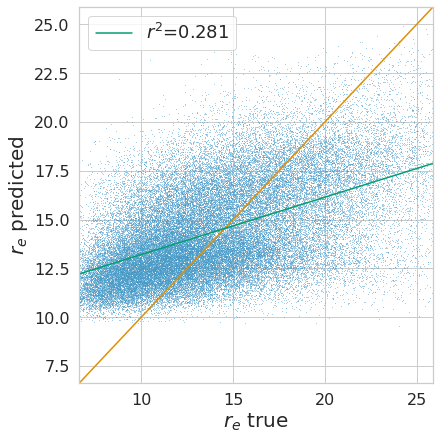

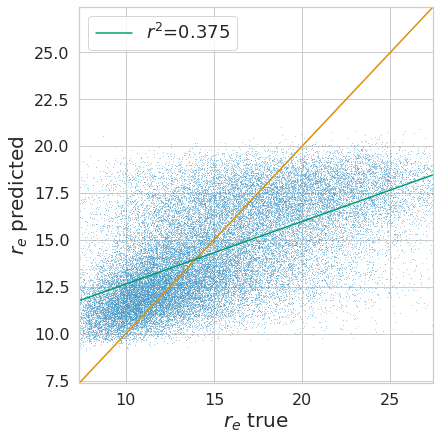

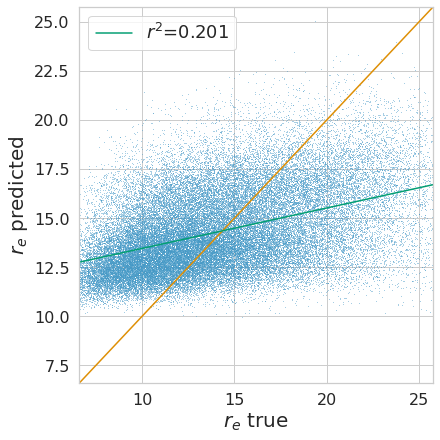

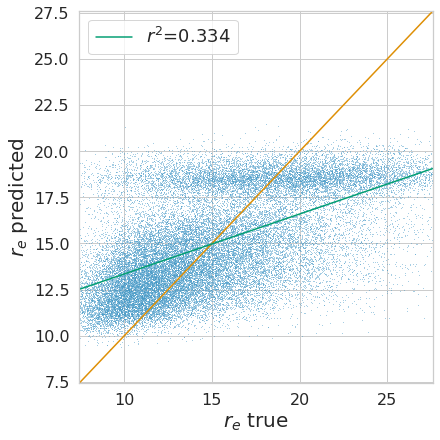

In [ ]:
plot_scatterplot(tr_pacific, 0, '/users/ms21mmso/msc-project/msc-project-report/figures/overcast/scatterplot_tr_lrp_re')
plot_scatterplot(tr_atlantic, 0, '/users/ms21mmso/msc-project/msc-project-report/figures/overcast/scatterplot_tr_lra_re')
plot_scatterplot(nn_pacific, 0, '/users/ms21mmso/msc-project/msc-project-report/figures/overcast/scatterplot_nn_lrp_re')
plot_scatterplot(nn_atlantic, 0, '/users/ms21mmso/msc-project/msc-project-report/figures/overcast/scatterplot_nn_lra_re')

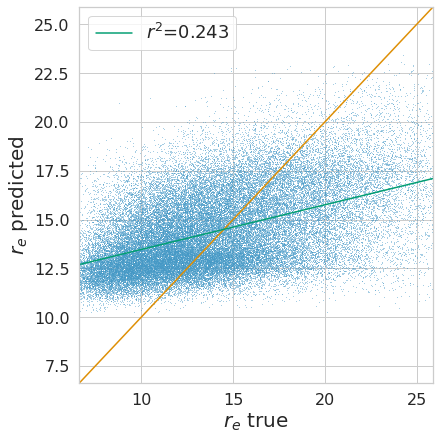

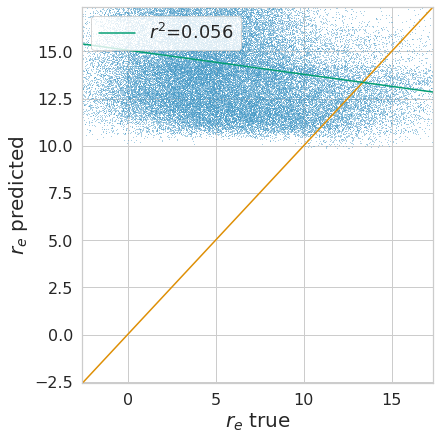

In [141]:
plot_scatterplot(tr_pacific_without_rh, 0, '/users/ms21mmso/msc-project/msc-project-report/figures/overcast/scatterplot_tr_lrprh_re')
plot_scatterplot(tr_pacific_without_w500, 0, '/users/ms21mmso/msc-project/msc-project-report/figures/overcast/scatterplot_tr_lrpw500_re')

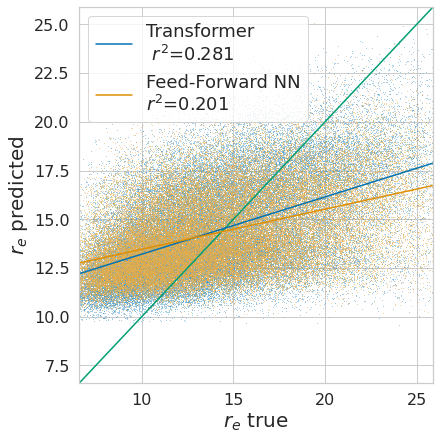

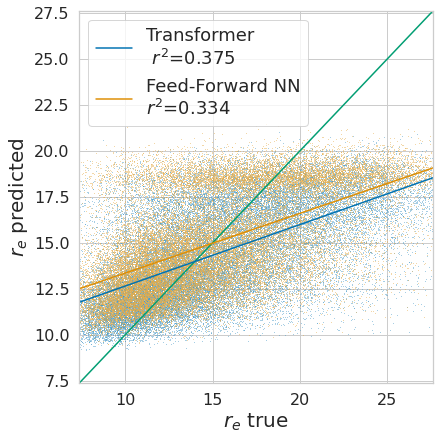

In [ ]:
plot_scatterplot_tr_nn(tr_pacific, nn_pacific, 0, '/users/ms21mmso/msc-project/msc-project-report/figures/overcast/scatterplot_tr-vs-nn_lrp_re')
plot_scatterplot_tr_nn(tr_atlantic, nn_atlantic, 0, '/users/ms21mmso/msc-project/msc-project-report/figures/overcast/scatterplot_tr-vs-nn_lra_re')

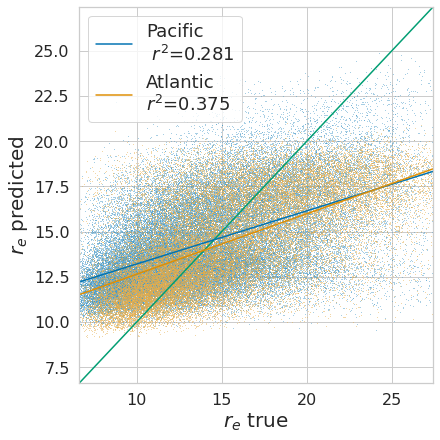

In [ ]:
plot_scatterplot_lrp_lra(tr_pacific, tr_atlantic, 0, '/users/ms21mmso/msc-project/msc-project-report/figures/overcast/scatterplot_tr_lpr-vs-lra_re')

In [14]:
def plot_apo_1(experiment, idx_outcome, savepath=None):
    alpha = 0.05
    plt.figure()
    _ = sns.lineplot(x=experiment.treatments, y=experiment.apos_ensemble[idx_outcome].mean(0))
    _ = plt.fill_between(
        x=experiment.treatments,
        y1=np.quantile(experiment.apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
        y2=np.quantile(experiment.apos_ensemble[idx_outcome], alpha / 2, axis=0),
        alpha=0.2,
        label=r"$\Lambda \to 1.0 $",
    )
    _ = plt.legend(
        title=r"$\alpha=$" + f"{alpha}",
        loc="upper right",
    )
    _ = plt.ylabel(TARGET_KEYS[experiment.target_keys[idx_outcome]])
    _ = plt.xlabel("AOD")
    if savepath is not None:
        plt.savefig(f'{savepath}.pdf', format="pdf", bbox_inches='tight')

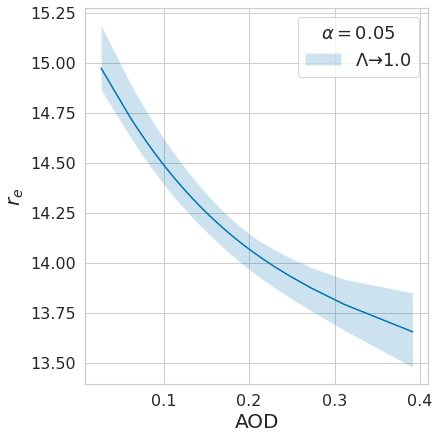

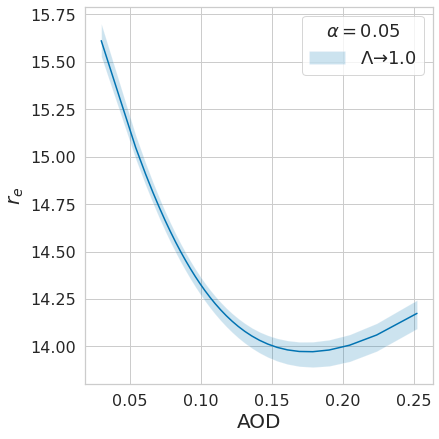

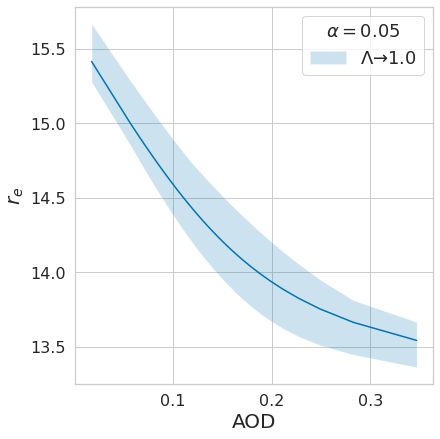

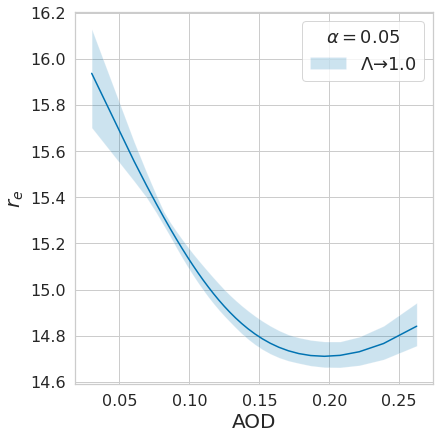

In [ ]:
plot_apo_1(tr_pacific, 0, '/users/ms21mmso/msc-project/msc-project-report/figures/overcast/apo_tr_lrp_re')
plot_apo_1(nn_pacific, 0, '/users/ms21mmso/msc-project/msc-project-report/figures/overcast/apo_nn_lrp_re')
plot_apo_1(tr_atlantic, 0, '/users/ms21mmso/msc-project/msc-project-report/figures/overcast/apo_tr_lra_re')
plot_apo_1(nn_atlantic, 0, '/users/ms21mmso/msc-project/msc-project-report/figures/overcast/apo_nn_lra_re')

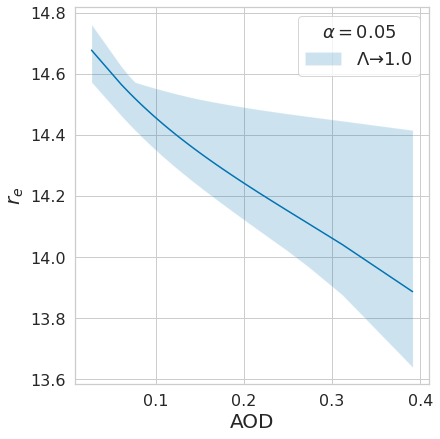

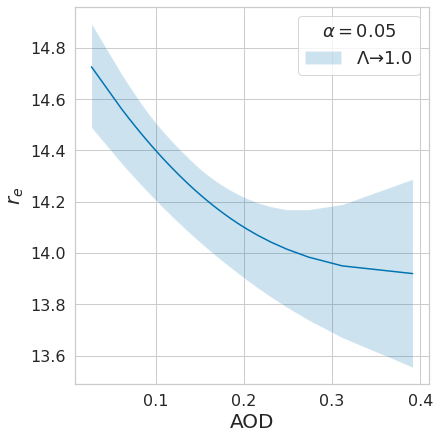

In [15]:
plot_apo_1(tr_pacific_without_rh, 0, '/users/ms21mmso/msc-project/msc-project-report/figures/overcast/apo_tr_lrprh_re')
plot_apo_1(tr_pacific_without_w500, 0, '/users/ms21mmso/msc-project/msc-project-report/figures/overcast/apo_tr_lrpw500_re')

In [ ]:
def plot_apo_tr_nn(experiments, idx_outcome, savepath=None):
    alpha = 0.05
    plt.figure()
    for experiment in experiments:
        scaler = MinMaxScaler().fit(
            experiment.apos_ensemble[idx_outcome].mean(0).reshape(-1, 1)
        )
        _ = plt.plot(
            experiment.treatments, 
            scaler.transform(
                experiment.apos_ensemble[idx_outcome].mean(0).reshape(-1, 1)
            ),
            label='Transformer' if 'with context' in experiment.name else 'Feed-Forward NN',
        )
        _ = plt.fill_between(
            x=experiment.treatments,
            y1=scaler.transform(
                np.quantile(
                    experiment.apos_ensemble[idx_outcome],
                    1 - alpha / 2,
                    axis=0,
                ).reshape(-1, 1)
            ).flatten(),
            y2=scaler.transform(
                np.quantile(
                    experiment.apos_ensemble[idx_outcome],
                    alpha / 2,
                    axis=0
                ).reshape(-1, 1)    
            ).flatten(),        
            alpha=0.2,
            label=r"$\Lambda \to 1.0 $",
        )
        _ = plt.legend(
            title=r"$\alpha=$" + f"{alpha}",
            loc="upper right",
        )
    _ = plt.xlim([0.02, 0.25])
    _ = plt.ylabel(TARGET_KEYS[experiment.target_keys[idx_outcome]])
    _ = plt.xlabel("AOD")
    if savepath is not None:
        plt.savefig(f'{savepath}.pdf', format="pdf", bbox_inches='tight')

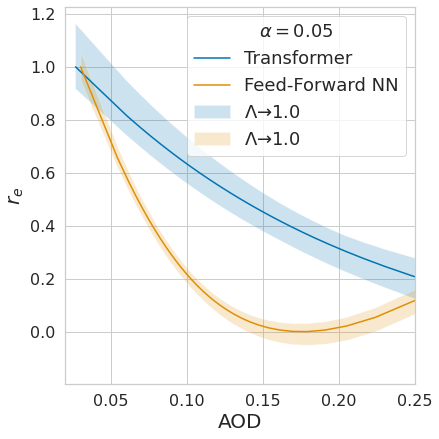

In [ ]:
plot_apo_tr_nn([tr_pacific, nn_pacific], 0, '/users/ms21mmso/msc-project/msc-project-report/figures/overcast/apo_tr-vs-nn_lrp_re')

In [40]:
def plot_apo_lrp_lra(experiments, idx_outcome, savepath=None):
    alpha = 0.05
    plt.figure()
    for experiment in experiments:
        scaler = MinMaxScaler().fit(
            experiment.apos_ensemble[idx_outcome].mean(0).reshape(-1, 1)
        )
        _ = plt.plot(
            experiment.treatments, 
            scaler.transform(
                experiment.apos_ensemble[idx_outcome].mean(0).reshape(-1, 1)
            ),
            label='Pacific' if 'Pacific' in experiment.name else 'Atlantic',
        )
        _ = plt.fill_between(
            x=experiment.treatments,
            y1=scaler.transform(
                np.quantile(
                    experiment.apos_ensemble[idx_outcome],
                    1 - alpha / 2,
                    axis=0,
                ).reshape(-1, 1)
            ).flatten(),
            y2=scaler.transform(
                np.quantile(
                    experiment.apos_ensemble[idx_outcome],
                    alpha / 2,
                    axis=0
                ).reshape(-1, 1)    
            ).flatten(),        
            alpha=0.2,
            label=r"$\Lambda \to 1.0 $",
        )
        _ = plt.legend(
            title=r"$\alpha=$" + f"{alpha}",
            loc="upper right",
        )
    _ = plt.xlim([0.03, 0.34])
    _ = plt.ylabel(TARGET_KEYS[experiment.target_keys[idx_outcome]])
    _ = plt.xlabel("AOD")
    if savepath is not None:
        plt.savefig(f'{savepath}.pdf', format="pdf", bbox_inches='tight')

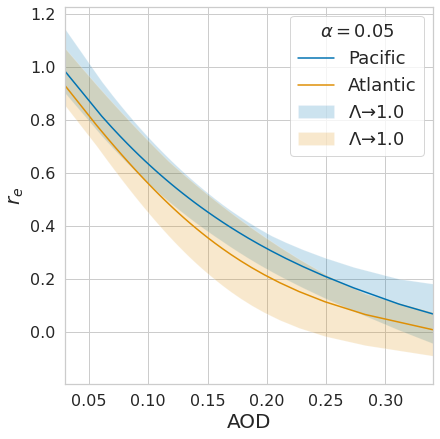

In [ ]:
plot_apo_lrp_lra([tr_pacific, tr_atlantic], 0, '/users/ms21mmso/msc-project/msc-project-report/figures/overcast/apo_tr_lrp-vs-lra_re')

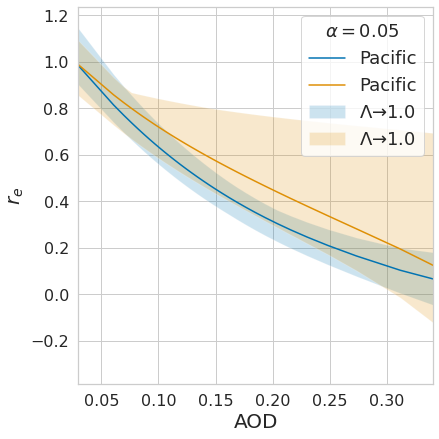

In [41]:
plot_apo_lrp_lra([tr_pacific, tr_pacific_without_rh], 0, '/users/ms21mmso/msc-project/msc-project-report/figures/overcast/apo_tr_lrp-vs-lrprh_re')

In [8]:
def plot_without_points(reference, comparison, labels, idx_outcome, log_lambda, savepath=None):
    alpha = 0.05
    reference_scaler = MinMaxScaler().fit(
        reference
        .apos_ensemble[idx_outcome]
        .mean(0)
        .reshape(-1, 1)
    )
    comparison_scaler = MinMaxScaler().fit(
        comparison
        .apos_ensemble[idx_outcome]
        .mean(0)
        .reshape(-1, 1)
    )
    _ = plt.plot(
        reference.treatments, 
        reference_scaler.transform(
            reference
            .apos_ensemble[idx_outcome]
            .mean(0)
            .reshape(-1, 1)
        ),
        label=labels[0],
        color='C0',
    )
    _ = plt.plot(
        comparison.treatments, 
        comparison_scaler.transform(
            comparison
            .apos_ensemble[idx_outcome]
            .mean(0)
            .reshape(-1, 1)
        ),
        label=labels[1],
        color='C1',
    )
    if log_lambda not in comparison.apo_limits: 
        comparison.get_apo_limits(log_lambda)
    _ = plt.fill_between(
        x=reference.treatments,
        y1=reference_scaler.transform(
            np.quantile(
                reference.apos_ensemble[idx_outcome],
                1 - alpha / 2,
                axis=0,
            ).reshape(-1, 1)
        ).flatten(),
        y2=reference_scaler.transform(
            np.quantile(
                reference.apos_ensemble[idx_outcome],
                alpha / 2,
                axis=0
            ).reshape(-1, 1)    
        ).flatten(),        
        alpha=0.2,
        color='C0',
        label=r"$\Lambda \to 1.0 $",
    )
    # _ = plt.fill_between(
    #     x=comparison.treatments,
    #     y1=comparison_scaler.transform(
    #         np.quantile(
    #             comparison.apo_limits[log_lambda][1][idx_outcome],
    #             1 - alpha / 2,
    #             axis=0,
    #         ).reshape(-1, 1)
    #     ).flatten(),
    #     y2=comparison_scaler.transform(
    #         np.quantile(
    #             comparison.apo_limits[log_lambda][0][idx_outcome],
    #             alpha / 2,
    #             axis=0
    #         ).reshape(-1, 1)
    #     ).flatten(),
    #     alpha=0.2,
    #     color='C1',
    #     label=r"$\Lambda=$" + f"{np.exp(log_lambda):.2f}",
    # )
    _ = plt.fill_between(
        x=reference.treatments,
        y1=comparison_scaler.transform(
            np.quantile(
                comparison.apo_limits[log_lambda][1][idx_outcome],
                1 - alpha / 2,
                axis=0,
            ).reshape(-1, 1)
        ).flatten(),
        y2=reference_scaler.transform(
            np.quantile(
                reference.apos_ensemble[idx_outcome],
                1 - alpha / 2,
                axis=0,
            ).reshape(-1, 1)
        ).flatten(),
        alpha=0.2,
        color='C1',
        label=r"$\Lambda=$" + f"{np.exp(log_lambda):.2f}",
    )
    _ = plt.fill_between(
        x=reference.treatments,
        y1=reference_scaler.transform(
            np.quantile(
                reference.apos_ensemble[idx_outcome],
                alpha / 2,
                axis=0
            ).reshape(-1, 1)    
        ).flatten(), 
        y2=comparison_scaler.transform(
            np.quantile(
                comparison.apo_limits[log_lambda][0][idx_outcome],
                alpha / 2,
                axis=0
            ).reshape(-1, 1)
        ).flatten(),
        alpha=0.2,
        color='C1',
    )
    _ = plt.legend(
        title=r"$\alpha=$" + f"{alpha}",
        loc="upper right",
        fontsize=14,
    )
    _ = plt.xlim([0.04, 0.3])
    _ = plt.ylabel(TARGET_KEYS[reference.target_keys[idx_outcome]])
    _ = plt.xlabel("AOD")
    if savepath is not None:
        plt.savefig(f'{savepath}.pdf', format="pdf", bbox_inches='tight')
    plt.show()

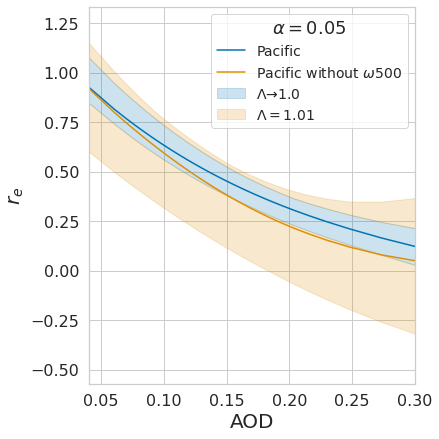

In [129]:
log_lambda = 0.01
plot_without_points(tr_pacific, tr_pacific_without_w500, ['Pacific', r'Pacific without $\omega500$'], 0, log_lambda, f'/users/ms21mmso/msc-project/msc-project-report/figures/overcast/apo_tr_lrp-vs-lrpw500_{log_lambda}_re')

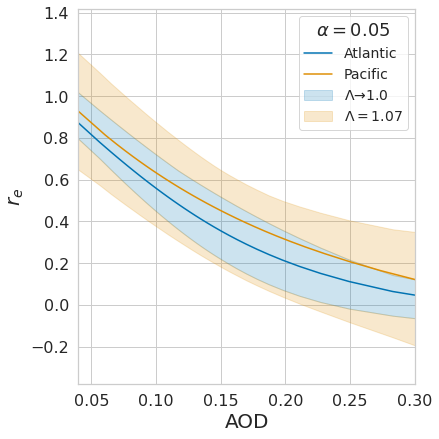

In [31]:
log_lambda = 0.07
plot_without_points(tr_atlantic, tr_pacific, ['Atlantic', 'Pacific'], 0, log_lambda, f'/users/ms21mmso/msc-project/msc-project-report/figures/overcast/apo_tr_lra-vs-lrp_{log_lambda}_re')

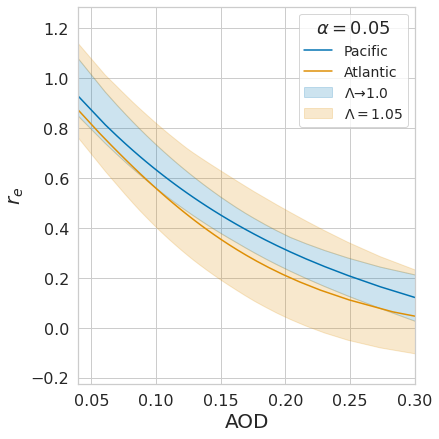

In [32]:
log_lambda = 0.05
plot_without_points(tr_pacific, tr_atlantic, ['Pacific', 'Atlantic'], 0, log_lambda, f'/users/ms21mmso/msc-project/msc-project-report/figures/overcast/apo_tr_lrp-vs-lra_{log_lambda}_re')

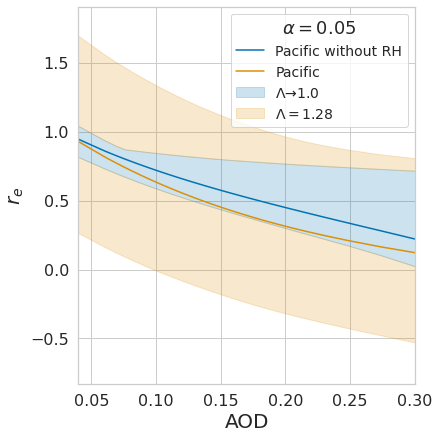

In [9]:
log_lambda = 0.25
plot_without_points(tr_pacific_without_rh, tr_pacific, ['Pacific without RH', 'Pacific'], 0, log_lambda, f'/users/ms21mmso/msc-project/msc-project-report/figures/overcast/apo_tr_lrp-vs-lrprh_{log_lambda}_re')

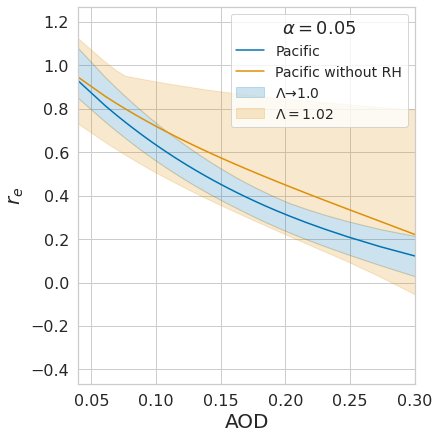

In [10]:
log_lambda = 0.02
plot_without_points(tr_pacific, tr_pacific_without_rh, ['Pacific', 'Pacific without RH'], 0, log_lambda, f'/users/ms21mmso/msc-project/msc-project-report/figures/overcast/apo_tr_lrp-vs-lrprh_{log_lambda}_re')

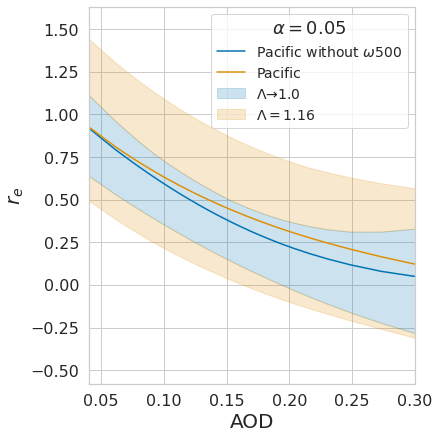

In [11]:
log_lambda = 0.15
plot_without_points(tr_pacific_without_w500, tr_pacific, ['Pacific without $\omega500$', 'Pacific'], 0, log_lambda, f'/users/ms21mmso/msc-project/msc-project-report/figures/overcast/apo_tr_lrpw500-vs-lrp_{log_lambda}_re')